## 데이터를 활용한 신경망 구축을 통해 전복의 나이 추정

In [ ]:
import numpy as np
import csv
np.random.seed(1541)

In [ ]:
rnd_mean=0
rnd_std=0.0030
learning_rate=0.001

In [ ]:
def main_exec(epoch_count=10,mb_size=10,report=1,train_rate=0.8):
  #학습 횟수,미니배치 크기,중간보고주기,학습데이터 비율
  load_dataset() #데이터 불러들임
  init_model() #가중치와 편향 초기화
  train_and_test(epoch_count,mb_size,report,train_rate)#학습 및 성능 테스트

In [ ]:
def load_dataset():
  with open('/content/drive/MyDrive/abalone.csv') as csvfile:
    csvreader=csv.reader(csvfile)
    next(csvreader,None) #열이름 제거
    rows=[]
    for row in csvreader:
      rows.append(row)
    global data,input_cnt,output_cnt #전역변수로 다른 함수에서 활용될 예정
    input_cnt,output_cnt=10,1 #원핫벡터를 통해 10으로 증가
    data=np.zeros([len(rows),input_cnt+output_cnt])
    for n,row in enumerate(rows):#원핫벡터 변환
      if row[0]=='I': data[n,0]=1
      if row[0]=='M': data[n,1]=1
      if row[0]=='F': data[n,2]=1
      data[n,3:]=row[1:]#3열부터는 그대로

In [ ]:
def init_model():
  global weight,bias,input_cnt,output_cnt
  weight=np.random.normal(rnd_mean,rnd_std,[input_cnt,output_cnt])
  #정규분포를 갖는 난수값으로 초기화->local minimum을 피할 가능성을 높일 의도
  bias=np.zeros([output_cnt]) #편향

In [ ]:
def train_and_test(epoch_count,mb_size,report,train_rate):
  step_count=arrange_data(mb_size,train_rate)#전체 데이터셋을 무작위로 섞음.1에폭당 미니배치 스텝수 계산
  test_x,test_y=get_test_data() #테스트 데이터 분리 후 독립변수,종속변수 분할
  for epoch in range(epoch_count):#step count가 다 돌면 1 epoch이 수행
    losses,accs=[],[]
    for n in range(step_count):
      train_x,train_y=get_train_data(mb_size,n)#mb_size만큼 미니배치 수행, 독립변수와 종속변수로 나뉨
      loss,acc=run_train(train_x,train_y)# 순전파,역전파가 수행되며 학습이 진행.손실값과 정확도 반환
      losses.append(loss)
      accs.append(acc)
    if report>0 and (epoch+1)%report==0:
      acc=run_test(test_x,test_y)
      print("Epoch{}: Train - loss = {:5.3f}, accuracy = {:5.3f} / Test={:5.3f}".\
          format(epoch+1, np.mean(losses), np.mean(accs),acc))
  final_acc = run_test(test_x,test_y)#테스트 데이터에 대한 acc 반환.손실값,정확도,미니배치 처리된 데이터에서 losses,accs평균값,
  #테스트 데이터를 통한 정확도 출력
  print('\n 최종 테스트 : final accuracy = {:5.3f}'.format(final_acc))

In [ ]:
def arrange_data(mb_size,train_rate):
  global data,shuffle_map,test_begin_index
  shuffle_map=np.arange(data.shape[0]) #인덱스 생성
  np.random.shuffle(shuffle_map) #인덱스 무작위 셔플
  step_count=int(data.shape[0]*train_rate)//mb_size #1차례 에폭을 수행하기 위한 미니배치 스텝 수
  test_begin_index=step_count*mb_size #학습데이터 경계 인덱스
  return step_count

In [ ]:
def get_test_data():
  global data,shuffle_map,test_begin_index,output_cnt
  test_data=data[shuffle_map[test_begin_index:]]
  return test_data[:,:-output_cnt],test_data[:,-output_cnt:]
def get_train_data(mb_size,nth):
  global data,shuffle_map,test_begin_index,output_cnt
  if nth==0:
    np.random.shuffle(shuffle_map[:test_begin_index])
  train_data=data[shuffle_map[mb_size*nth:mb_size*(nth+1)]]
  return train_data[:,:-output_cnt],train_data[:,-output_cnt:]

In [ ]:
def run_train(x,y):
  output,aux_nn=forward_neuralnet(x)
  loss,aux_pp=forward_postproc(output,y) #순전파 과정으로 예측에 대한 손실 구하기
  accuracy=eval_accuracy(output,y) #예측된 값을 바탕으로 정확도 산출
  g_loss=1.0
  g_output=backprop_postproc(aux_pp)#모든 요소에 대한 기울기 구하는 과정
  backprop_neuralnet(g_output,aux_nn)
  return loss,accuracy

def run_test(x,y):
  output,_=forward_neuralnet(x)
  accuracy=eval_accuracy(output,y)
  return accuracy

In [ ]:
#mse를 구하는 과정: 예측값과 실제값의 편차,편차값에 대한 제곱,제곱의 평균
def forward_postproc(output, y):
  diff = output - y
  square = np.square(diff)
  loss = np.mean(square)
  return loss, diff

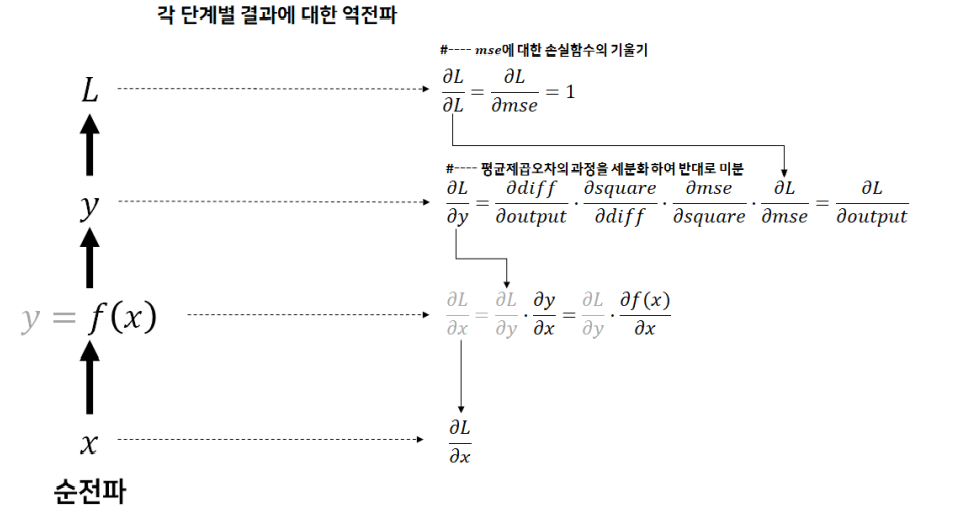

In [ ]:
#역전파 과정:순전파 과정이 수행해온 방법을 반대로 수행->손실함수로 출력된 결과에 영향을 미친 모든 원소에
#조금씩 변화. 미분을 통한 값의 갱신을 수행
#최종값을 통해 파라미터 값을 경신->학습률을 곱해 값의 갱신 보폭을 조정,기존 파라미터 값에서 빼줌으로 실질적인 
#파라미터 값의 갱신이 이뤄지게 된다.
#1. 입력값에 따른 손실함수의 기울기
#2. 입력된 파라미터 값에 따른 y의 미분을 구함(ay/ax)
#3. 순전파 단계인 y에 대한 역전파 aL/ay를 구하는 과정
#g_loss는 aL/amse로 변하지 않는 값이다.
def backprop_postproc(diff):
  shape=diff.shape
  g_loss=1 #aL/amse
  g_loss_square=np.ones(shape)/np.prod(shape) #amse/asquare
  g_square_diff=2*diff #square와 diff의 기울기
  g_diff_output=1 #g_diff에 대한 output의 기울기
  g_square=g_loss_square*g_loss
  g_diff=g_square_diff*g_square
  g_output=g_diff_output*g_diff
  return g_output

In [ ]:
def forward_neuralnet(x): #순전파 과정ef forward_neuralnet(x): #순전파 과정
  global weight,bias
  output=np.matmul(x,weight)+bias
  return output,x

In [ ]:
def backprop_neuralnet(g_output,x):
  global weight,bias
  g_output_w=x.transpose()#x는 전치가 필요하다 이유는 가중치의 손실기울기를 구하기 위해서다
  g_w=np.matmul(g_output_w,g_output)
  g_b=np.sum(g_output,axis=0) #편향의 손실 기울기
  weight-=learning_rate*g_w #파라미터 가중치가 새로운 값을 가지게 함
  bias-=learning_rate*g_b #갱신식 완성

In [ ]:
#신경망 연산을 통한 결과 도출과 도출된 결과를 통한 평가가 들어감
def eval_accuracy(output, y):
  mdiff = np.mean(np.abs((output - y)/y))
  return 1-mdiff

In [ ]:
#main_exec()

Epoch1: Train - loss = 33.949, accuracy = 0.558 / Test=0.802
Epoch2: Train - loss = 8.299, accuracy = 0.821 / Test=0.808
Epoch3: Train - loss = 7.600, accuracy = 0.813 / Test=0.803
Epoch4: Train - loss = 7.497, accuracy = 0.811 / Test=0.802
Epoch5: Train - loss = 7.422, accuracy = 0.809 / Test=0.804
Epoch6: Train - loss = 7.358, accuracy = 0.810 / Test=0.804
Epoch7: Train - loss = 7.304, accuracy = 0.810 / Test=0.803
Epoch8: Train - loss = 7.255, accuracy = 0.809 / Test=0.805
Epoch9: Train - loss = 7.213, accuracy = 0.811 / Test=0.803
Epoch10: Train - loss = 7.176, accuracy = 0.809 / Test=0.805

 최종 테스트 : final accuracy = 0.805


In [ ]:
print(weight)
print(bias)

[[1.02551138]
 [1.49670838]
 [1.63657094]
 [2.03653185]
 [1.60914806]
 [0.5950352 ]
 [2.39984928]
 [0.54612041]
 [0.47700024]
 [1.03126537]]
[4.16026418]
